# Unsupervised ML Analysis — API Logs

Se importan librerías de Python para análisis de datos (pandas, numpy), machine learning (scikit-learn), y visualización (matplotlib).

Se define la ruta del archivo CSV (api_logs_ml_ready.csv) y una semilla aleatoria para reproducibilidad.

In [20]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.ensemble import IsolationForest

import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
DATA_PATH = 'api_logs_ml_ready.csv' 
RANDOM_STATE = 42


Se carga el CSV con los logs de tráfico de API.
Se muestra la forma del DataFrame y las primeras filas.
Si existe una columna de etiqueta (label, target, etc.), se elimina para asegurar que el análisis sea no supervisado.

In [21]:
# === Load Data ===
df = pd.read_csv(DATA_PATH)
print('Shape:', df.shape)
display(df.head())

# If there's an obvious label column (e.g., 'label', 'target'), we won't use it.
possible_labels = [c for c in df.columns if c.lower() in {'label_attack', 'user_agent'}]
if possible_labels:
    print('Ignoring potential label columns:', possible_labels)
    X_raw = df.drop(columns=possible_labels)
else:
    X_raw = df.copy()


Shape: (3598, 16)


,timestamp,http_method,endpoint,query_params_count,user_agent,authorization_present,ip_hash,content_length_bytes,num_fields,avg_field_length,failed_auth_attempts_last_10min,suspicious_patterns_detected,statusCode,duration_ms,responseSize,label_attack
0,2025-09-03T06:23:33.316Z,POST,/api/v1/book,0,python-requests/2.32.5,True,ddf72b6676cb429c9adf5335634fdb407bf3319e34499d...,81,3,12.333333,1,"authorization_header_present,suspicious_quotes...",201,28.06,217,0
1,2025-09-03T06:23:33.354Z,GET,/api/v1/book,0,python-requests/2.32.5,True,ddf72b6676cb429c9adf5335634fdb407bf3319e34499d...,0,0,0.000000,1,"authorization_header_present,suspicious_quotes...",200,124.16,110323,0
2,2025-09-03T06:23:34.313Z,POST,/api/v1/auth/signup,0,python-requests/2.32.5,False,ddf72b6676cb429c9adf5335634fdb407bf3319e34499d...,54,2,11.000000,1,suspicious_quotes_or_escape,201,129.52,61,0
3,2025-09-03T06:23:34.449Z,POST,/api/v1/auth/signin,0,python-requests/2.32.5,False,ddf72b6676cb429c9adf5335634fdb407bf3319e34499d...,54,2,11.000000,1,suspicious_quotes_or_escape,201,170.61,251,0
4,2025-09-03T06:23:34.627Z,POST,/api/v1/book,0,python-requests/2.32.5,True,ddf72b6676cb429c9adf5335634fdb407bf3319e34499d...,81,3,12.333333,1,"authorization_header_present,suspicious_quotes...",201,12.80,217,0


Ignoring potential label columns: ['user_agent', 'label_attack']


Se muestra el tipo de cada columna.
Se analiza la cantidad de valores nulos por columna para decidir si hay que imputar o eliminar datos.

In [22]:
# === Basic Info & Missingness ===
display(pd.DataFrame({'dtype': X_raw.dtypes.astype(str)}))
missing = X_raw.isna().sum().sort_values(ascending=False)
display(pd.DataFrame({'missing': missing[missing > 0]}))


,dtype
timestamp,object
http_method,object
endpoint,object
query_params_count,int64
authorization_present,bool
ip_hash,object
content_length_bytes,int64
num_fields,int64
avg_field_length,float64
failed_auth_attempts_last_10min,int64


,missing


Se identifican columnas numéricas y categóricas.
Se evita codificar variables categóricas con demasiados valores únicos (alta cardinalidad).
Se crea un pipeline para:
Imputar valores faltantes en numéricas (mediana) y categóricas (más frecuente).
Escalar numéricas y codificar categóricas con one-hot.
Se transforma el DataFrame en una matriz de características lista para ML.

In [23]:
# === Preprocessing ===
# Identify numeric & categorical columns
numeric_cols = X_raw.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X_raw.columns if c not in numeric_cols]

# Guard against extremely high-cardinality categorical features
# (helps keep the one-hot expansion within reason)
high_cardinality_threshold = 200
safe_categoricals = []
for c in categorical_cols:
    nunique = X_raw[c].nunique(dropna=True)
    if nunique <= high_cardinality_threshold:
        safe_categoricals.append(c)
    else:
        print(f"Skipping high-cardinality categorical column: {c} ({nunique} unique)")

categorical_cols = safe_categoricals

numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scale", RobustScaler()),
    ("pt", PowerTransformer(method="yeo-johnson"))
])

categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore")),
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_cols),
        ('cat', categorical_pipeline, categorical_cols)
    ],
    remainder='drop', sparse_threshold=0.3
)

X = preprocess.fit_transform(X_raw)
print('Transformed feature matrix shape:', X.shape)


Skipping high-cardinality categorical column: timestamp (3583 unique)
Transformed feature matrix shape: (3598, 207)


Se aplica PCA para reducir la dimensionalidad y explorar la varianza explicada por los componentes principales.
Se visualiza la varianza explicada y se proyectan los datos en 2D para facilitar la visualización de clusters.

Explained variance ratio (first 10 PCs max):
0    0.432345
1    0.218916
2    0.111985
3    0.089367
4    0.044651
5    0.024779
6    0.019063
7    0.008834
8    0.008317
9    0.006500
dtype: float64


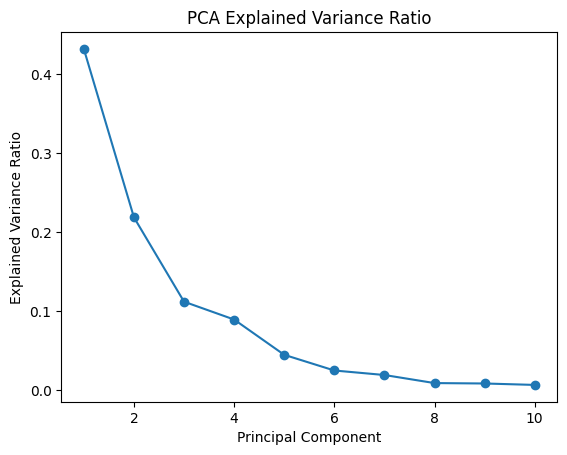

In [24]:
# === PCA Exploration ===
# Keep up to 10 principal components (or fewer if features < 10)
n_components = int(min(10, X.shape[1]))
pca = PCA(n_components=n_components, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X)

explained = pca.explained_variance_ratio_
print('Explained variance ratio (first 10 PCs max):')
print(pd.Series(explained))

# Plot explained variance ratio
plt.figure()
plt.plot(np.arange(1, len(explained)+1), explained, marker='o')
plt.title('PCA Explained Variance Ratio')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

# 2D projection for visualization
if X_pca.shape[1] >= 2:
    pca2 = X_pca[:, :2]
else:
    # Fallback to first component + zeros
    pca2 = np.column_stack([X_pca[:, 0], np.zeros(X_pca.shape[0])])


Se prueba K-Means con distintos valores de k (número de clusters).
Se calcula la inercia (elbow) y el score de silueta para elegir el mejor k.
Se visualizan los clusters en el espacio PCA 2D.

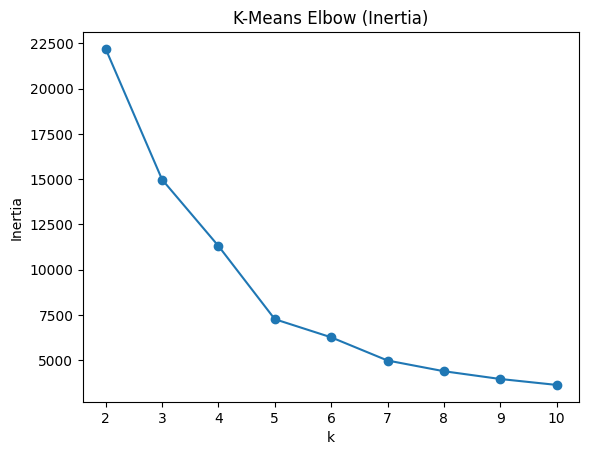

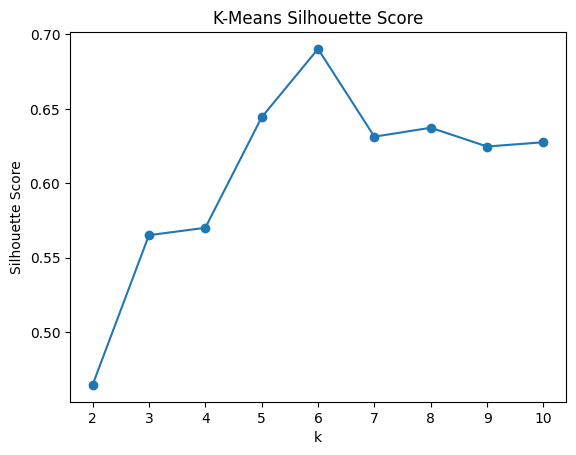

Chosen k: 6


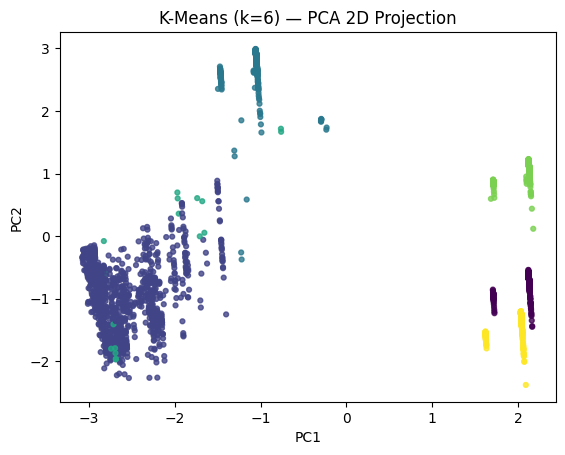

    k       inertia  silhouette_mean
0   2  22191.025623         0.464587
1   3  14975.994560         0.565167
2   4  11305.805508         0.570128
3   5   7259.910441         0.644347
4   6   6258.549379         0.690277
5   7   4976.872860         0.631339
6   8   4385.062612         0.637328
7   9   3955.796667         0.624720
8  10   3628.211718         0.627613


In [25]:
# === K-Means: Elbow & Silhouette ===
k_range = list(range(2, min(11, max(3, X.shape[0]//10))))
inertias = []
silhouettes = []

for k in k_range:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init='auto')
    labels = km.fit_predict(X)
    inertias.append(km.inertia_)
    try:
        sil = silhouette_score(X, labels) if len(set(labels)) > 1 else np.nan
    except Exception:
        sil = np.nan
    silhouettes.append(sil)

# Plot elbow (inertia)
plt.figure()
plt.plot(k_range, inertias, marker='o')
plt.title('K-Means Elbow (Inertia)')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()

# Plot silhouette
plt.figure()
plt.plot(k_range, silhouettes, marker='o')
plt.title('K-Means Silhouette Score')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.show()

# Pick best k by max silhouette (fall back to 2 if all nan)
if np.all(np.isnan(silhouettes)):
    best_k = 2
else:
    best_k = int(k_range[int(np.nanargmax(silhouettes))])

print('Chosen k:', best_k)
km_best = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init='auto')
kmeans_labels = km_best.fit_predict(X)

# Visualize clusters in PCA 2D
plt.figure()
plt.scatter(pca2[:, 0], pca2[:, 1], s=12, alpha=0.8, c=kmeans_labels)
plt.title(f'K-Means (k={best_k}) — PCA 2D Projection')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

df_results = pd.DataFrame({
    'k': k_range,
    'inertia': inertias,
    'silhouette_mean': silhouettes
})

print(df_results)

Se prueba DBSCAN con distintos valores de eps para encontrar agrupaciones densas.
Se calcula el score de silueta para cada configuración.
Se visualiza el mejor clustering encontrado en el espacio PCA 2D.

Best DBSCAN eps: 2.257142857142857
Best DBSCAN silhouette: 0.6456440319268136
Best DBSCAN best_db_labels: {0, 1, 2, 3, 4, 5, -1}


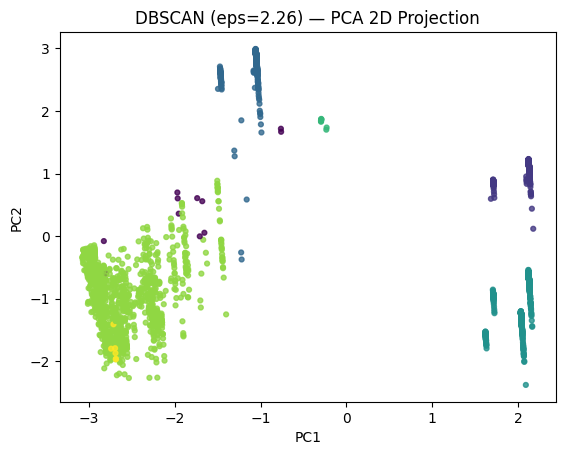

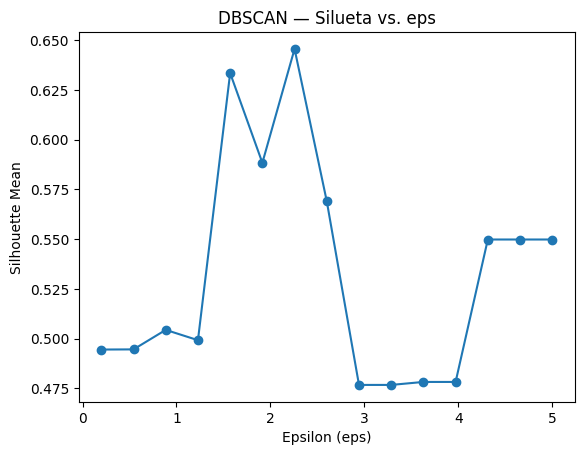

In [30]:
# === DBSCAN (eps sweep) ===
# Use k-dist heuristic range around typical scale; try a small grid
eps_grid = np.linspace(0.2, 5.0, 15)
best_dbscan_sil = -1
best_dbscan = None
best_db_labels = None

silhouettes_dbscan = []

for eps in eps_grid:
    db = DBSCAN(eps=eps, min_samples=5)
    labels = db.fit_predict(X)
    n_labels = len(set(labels)) - (1 if -1 in labels else 0)
    if n_labels <= 1:
        continue
    try:
        sil = silhouette_score(X, labels)
    except Exception:
        sil = -1
    if sil > best_dbscan_sil:
        best_dbscan_sil = sil
        best_dbscan = db
        best_db_labels = labels
    silhouettes_dbscan.append({
        "eps": float(np.round(eps, 4)),
        "silhouette_mean": float(sil) if sil is not None else np.nan
    })
    

if best_dbscan is not None:
    print('Best DBSCAN eps:', best_dbscan.eps)
    print('Best DBSCAN silhouette:', best_dbscan_sil)
    print('Best DBSCAN best_db_labels:', set(best_db_labels.tolist()))
    # Visualize in PCA 2D
    plt.figure()
    plt.scatter(pca2[:, 0], pca2[:, 1], s=12, alpha=0.8, c=best_db_labels)
    plt.title(f'DBSCAN (eps={best_dbscan.eps:.2f}) — PCA 2D Projection')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.show()
    
    df_results = pd.DataFrame(silhouettes_dbscan)
    plt.figure()
    plt.plot(df_results["eps"], df_results["silhouette_mean"], marker="o")
    plt.xlabel("Epsilon (eps)")
    plt.ylabel("Silhouette Mean")
    plt.title(f"DBSCAN — Silueta vs. eps")
    plt.show()
    
else:
    print('DBSCAN did not find a suitable clustering with >1 cluster for the tried eps values.')


Se entrena un Isolation Forest para detectar anomalías de forma no supervisada.
Se calcula el score de anomalía y se asigna una etiqueta (1 para anomalía, 0 para normal).
Se visualiza la distribución de scores y se muestran las principales anomalías detectadas (las filas con menor score).

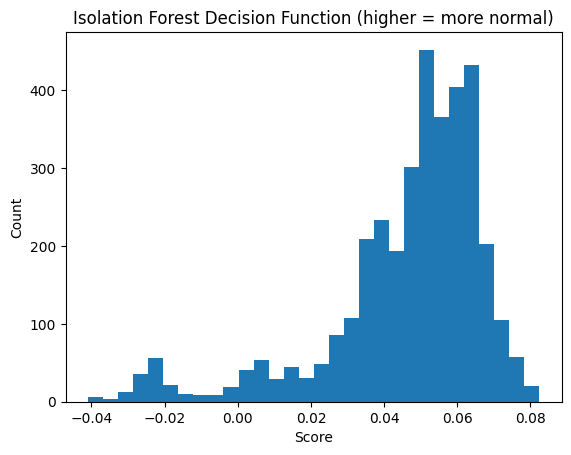

,timestamp,http_method,endpoint,query_params_count,user_agent,authorization_present,ip_hash,content_length_bytes,num_fields,avg_field_length,failed_auth_attempts_last_10min,suspicious_patterns_detected,statusCode,duration_ms,responseSize,label_attack
1058,2025-09-03T06:29:21.064Z,POST,/api/v1/auth/signup,0,python-requests/2.32.5,False,ddf72b6676cb429c9adf5335634fdb407bf3319e34499d...,54,2,11.0,1,suspicious_quotes_or_escape,201,1132.46,61,0
1579,2025-09-03T06:31:57.411Z,POST,/api/v1/auth/signin,0,python-requests/2.32.5,False,ddf72b6676cb429c9adf5335634fdb407bf3319e34499d...,54,2,11.0,2,suspicious_quotes_or_escape,201,227.17,252,0
10,2025-09-03T06:23:36.956Z,POST,/api/v1/auth/signup,0,python-requests/2.32.5,False,ddf72b6676cb429c9adf5335634fdb407bf3319e34499d...,54,2,11.0,1,suspicious_quotes_or_escape,201,499.86,61,0
2302,2025-09-03T06:35:44.211Z,POST,/api/v1/auth/signup,0,python-requests/2.32.5,False,ddf72b6676cb429c9adf5335634fdb407bf3319e34499d...,54,2,11.0,1,suspicious_quotes_or_escape,201,511.81,61,0
1023,2025-09-03T06:29:10.612Z,POST,/api/v1/auth/signin,0,python-requests/2.32.5,False,ddf72b6676cb429c9adf5335634fdb407bf3319e34499d...,54,2,11.0,2,suspicious_quotes_or_escape,201,251.98,251,0
1455,2025-09-03T06:31:20.819Z,POST,/api/v1/auth/signin,0,python-requests/2.32.5,False,ddf72b6676cb429c9adf5335634fdb407bf3319e34499d...,54,2,11.0,2,suspicious_quotes_or_escape,201,241.35,251,0
354,2025-09-03T06:25:24.890Z,POST,/api/v1/auth/signup,0,python-requests/2.32.5,False,ddf72b6676cb429c9adf5335634fdb407bf3319e34499d...,54,2,11.0,2,suspicious_quotes_or_escape,201,190.19,61,0
2231,2025-09-03T06:35:21.275Z,POST,/api/v1/auth/signin,0,python-requests/2.32.5,False,ddf72b6676cb429c9adf5335634fdb407bf3319e34499d...,54,2,11.0,1,suspicious_quotes_or_escape,201,693.46,252,0
2226,2025-09-03T06:35:19.833Z,POST,/api/v1/auth/signup,0,python-requests/2.32.5,False,ddf72b6676cb429c9adf5335634fdb407bf3319e34499d...,54,2,11.0,2,suspicious_quotes_or_escape,201,176.42,61,0
2206,2025-09-03T06:35:13.325Z,POST,/api/v1/auth/signup,0,python-requests/2.32.5,False,ddf72b6676cb429c9adf5335634fdb407bf3319e34499d...,54,2,11.0,2,suspicious_quotes_or_escape,201,172.55,61,0


In [27]:
# === Isolation Forest (Anomaly Detection) ===
contamination = 0.05 if X.shape[0] >= 40 else 0.1
iso = IsolationForest(random_state=RANDOM_STATE, contamination=contamination)
anomaly_scores = -iso.fit_predict(X)  # 1 for anomaly, 0 for normal (after transform below)
decision_function = iso.decision_function(X)  # higher = more normal

# Normalize anomaly labels to {0,1}
anomaly_labels = (iso.predict(X) == -1).astype(int)

# Plot distribution of decision scores
plt.figure()
plt.hist(decision_function, bins=30)
plt.title('Isolation Forest Decision Function (higher = more normal)')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

# Show top suspected anomalies
top_n = min(20, X.shape[0])
top_anomalies_idx = np.argsort(decision_function)[:top_n]
display(df.iloc[top_anomalies_idx])

In [28]:
# === Save Outputs ===
out_df = df.copy()
out_df['kmeans_cluster'] = kmeans_labels

if 'best_db_labels' in locals() and best_db_labels is not None:
    out_df['dbscan_cluster'] = best_db_labels
else:
    out_df['dbscan_cluster'] = np.nan

out_df.to_csv('api_logs_with_clusters.csv', index=False)
print('api_logs_with_clusters.csv')

an_df = pd.DataFrame({
    'decision_function': decision_function,
    'is_anomaly': anomaly_labels
})
an_df.to_csv('api_logs_anomaly_scores.csv', index=False)
print('Saved api_logs_anomaly_scores.csv')


api_logs_with_clusters.csv
Saved api_logs_anomaly_scores.csv
